In [1]:
import pandas as pd
import glob
from tqdm.notebook import tqdm

DIR = '../data/study_2_data' # data files pertaining to this specific research project
LARGEDATA = '../data/large' # large datasets that you need to download from FigShare
# This directory contains:
# PaperYear.csv
# PaperCitingOACount.csv
# PaperCountry.csv
# PaperCitingOACount_Q1PapersOnly.csv
# PaperCitingOACount_T3PapersOnly.csv
# These files are pre-computed using OpenAlex

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
def processWhiteRegion(row):

    r = row['region']
    sub = row['sub-region']
    country = row['country']

    if r == 'Asia' or r == 'Africa' or r=='Europe':
        return r
    elif r == 'Americas':
        return sub
    elif r == 'Oceania':
        if sub == 'Australia and New Zealand':
            return sub
        else:
            return r

def processNorthSouth(row):

    # Classify whether a country is Global North or Global South country
    # True: global south
    # False: global north

    r = row['region']
    sub = row['sub-region']
    country = row['country']

    if country == 'JP' or country == 'IL' or country == "KR":
        return False

    if r == 'Asia' or r == 'Africa':
        return True
    elif r == 'Americas':
        if sub == 'Latin America and the Caribbean':
            return True
        else: # north america
            return False
    elif r == 'Oceania':
        if sub == 'Australia and New Zealand':
            return False
        else:
            return True
    elif r == "Europe":
        return False
        

nonWhite = pd.DataFrame(
    {
        'ProcessedRegion': ['Asia', 'Africa', 'Oceania', 'Latin America and the Caribbean',
                   'Europe', 'Australia and New Zealand', 'Northern America'],
        'nonWhite': [True, True, True, True, False, False, False]
    }
)

continents = (
    pd.read_csv(f'../data/continents2.csv', usecols=['alpha-2', 'region', 'sub-region', 'name'])
    .rename(columns={'alpha-2': 'country'})
    .dropna()
    
    .assign(ProcessedRegion=lambda df: df.apply(processWhiteRegion, axis=1))
    .merge(nonWhite, on='ProcessedRegion')

    .assign(GlobalSouth=lambda df: df.apply(processNorthSouth, axis=1))
    .pipe(printShape, cols=['country'])

    .rename(columns={'country':'country_code'})
)

(247, 7)  country 247  


## Citation count to OA and non-OA papers

In [4]:
%%time
paperYear = pd.read_csv(f'{LARGEDATA}/PaperYear.csv').pipe(printShape) # 257748845

(257748845, 2)  
CPU times: user 35.7 s, sys: 2.53 s, total: 38.2 s
Wall time: 38.5 s


In [5]:
%%time
paperOA = (
    pd.read_csv(f'{LARGEDATA}/PaperCitingOACount.csv')
    .groupby(['CitingPaperID','is_oa'])['count'].sum().reset_index()
    .pipe(printShape) # 155981044
)

(155981044, 3)  
CPU times: user 2min 14s, sys: 5.23 s, total: 2min 19s
Wall time: 3min 40s


In [6]:
assert(paperOA.duplicated(subset=['CitingPaperID','is_oa']).any() == False)

In [7]:
%%time
authorCount = pd.read_csv(f'{LARGEDATA}/PaperAuthorCount.csv').pipe(printShape) # 235722554

(235722554, 2)  
CPU times: user 31.3 s, sys: 2.25 s, total: 33.5 s
Wall time: 1min 7s


In [8]:
%%time
papCountry = (
    pd.read_csv(f'{LARGEDATA}/PaperCountry.csv')
    .merge(authorCount, on='PaperID')
    .merge(continents, on='country_code')
    .pipe(printShape) # 123290382

    .assign(Percentage=lambda df: df.AuthorCount/df.Count)
)

(123290382, 10)  
CPU times: user 1min 22s, sys: 10.4 s, total: 1min 32s
Wall time: 3min 10s


In [9]:
%%time
papCountryAll = (
    papCountry.query('Percentage == 1')
    .pipe(printShape, cols=['PaperID'])
)
# (66490833, 11)  PaperID 65184898

(66490833, 11)  PaperID 65184898  
CPU times: user 19 s, sys: 1.5 s, total: 20.5 s
Wall time: 41.4 s


### Q1 and top journals

In [10]:
%%time
journalRanking = (
    pd.read_csv(f'{LARGEDATA}/JournalYearlyQuartile.csv')
    .rename(columns={'SJR Best Quartile':'Quartile'})
)

Q1 = journalRanking.query('Year == 2023 & Quartile == "Q1"').pipe(printShape, cols=['JournalID']).JournalID
# 8806

top3 = [
    137773608, # Nature
    125754415, # PNAS
    3880285, # Science
]

(8806, 7)  JournalID 8806  
CPU times: user 780 ms, sys: 54.6 ms, total: 835 ms
Wall time: 1.87 s


In [11]:
%%time
paperOAQ1 = pd.read_csv(f'{LARGEDATA}/PaperCitingOACount_Q1PapersOnly.csv').pipe(printShape)
paperOAT3 = pd.read_csv(f'{LARGEDATA}/PaperCitingOACount_T3PapersOnly.csv').pipe(printShape)
# (132440851, 3), (25408119, 3) 

(132440851, 3)  
(25408119, 3)  
CPU times: user 33.9 s, sys: 5.73 s, total: 39.6 s
Wall time: 1min 25s


### Aggregate by country year

In [12]:
def getCountryOA(paperOA, paperYear=paperYear, papCountryAll=papCountryAll, continents=continents):
    
    papOAYear = (
        pd.merge(
            paperOA.query('is_oa==True').rename(columns={'count':'OACount'}),
            paperOA.query('is_oa==False').rename(columns={'count':'nonOACount'}),
            on='CitingPaperID',
            how='outer'
        )
        .fillna({'nonOACount': 0, 'OACount': 0})
        
        .merge(paperYear.rename(columns={'PaperID': 'CitingPaperID'}), on='CitingPaperID')
        .pipe(printShape, cols=['CitingPaperID'])
    )
    
    countryOA = (
        papOAYear 
        .merge(papCountryAll.rename(columns={'PaperID':'CitingPaperID'}), on='CitingPaperID')

        # for each country, sum up the total number of references to OA and to non-OA papers
        .groupby('country_code').agg({'nonOACount': 'sum', 'OACount': 'sum', 'CitingPaperID': 'count'})
        .rename(columns={'CitingPaperID':'Total'})
        .reset_index()
        .assign(PercentNonOA=lambda df: df.nonOACount/(df.nonOACount + df.OACount))
        .pipe(printShape)

        .merge(continents, on='country_code')
        .pipe(printShape, msg='continent of countries')
    )
    
    return countryOA

In [13]:
%%time
countryOA = getCountryOA(paperOA)

(87336219, 6)  CitingPaperID 87336219  
(222, 5)  
(222, 11)  continent of countries
CPU times: user 2min 55s, sys: 16.6 s, total: 3min 12s
Wall time: 6min 31s


In [14]:
countryOA.groupby('GlobalSouth').PercentNonOA.mean() # 0.652724, 0.610695

GlobalSouth
False    0.652724
True     0.610695
Name: PercentNonOA, dtype: float64

In [15]:
%%time
countryOAQ1 = getCountryOA(paperOAQ1.rename(columns={'PaperID':'CitingPaperID'}))
countryOAT3 = getCountryOA(paperOAT3.rename(columns={'PaperID':'CitingPaperID'}))

(76808360, 6)  CitingPaperID 76808360  
(222, 5)  
(222, 11)  continent of countries
(18536461, 6)  CitingPaperID 18536461  
(221, 5)  
(221, 11)  continent of countries
CPU times: user 5min 19s, sys: 28.4 s, total: 5min 47s
Wall time: 11min 13s


## Plot distribution

In [16]:
import seaborn as sns

def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '$p$ < 0.001' if pVal < 0.001 else f'$p$ = {round(pVal, 3)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos , stars, ha='center', va='bottom', color=c)
    
    return yPos

In [17]:
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

Global north average 0.6527, global south average 0.6107


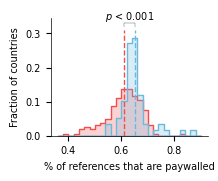

In [18]:
from scipy.stats import ttest_ind

bins = [x/100 for x in range(36, 92, 2)]

ax = plt.gca()

sns.histplot(
    countryOA, x="PercentNonOA", hue="GlobalSouth", element="step", bins=bins,
    stat="probability", common_norm=False, palette={True: '#f34d4d', False: '#69bade'}
)

whiteMean = countryOA.query('GlobalSouth==False').PercentNonOA.mean()
nonWhiteMean = countryOA.query('GlobalSouth==True').PercentNonOA.mean()

print(f'Global north average {whiteMean:.4f}, global south average {nonWhiteMean:.4f}')

plt.plot([whiteMean, whiteMean], [0, 0.31], color='#69bade', lw=1, ls='--')
plt.plot([nonWhiteMean, nonWhiteMean], [0, 0.31], color='#f34d4d', lw=1, ls='--')

tstat, p = ttest_ind(
    countryOA.query('GlobalSouth==False').PercentNonOA,
    countryOA.query('GlobalSouth==True').PercentNonOA
)

plotPvalue(ax, [whiteMean, nonWhiteMean], 0.31, pVal=p, gap=0.01, vlength=0.01)


set_size(4*cm, 3*cm, ax)

ax.set_xlabel('% of references that are paywalled')
ax.set_ylabel('Fraction of countries')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend([],[], frameon=False)

plt.savefig('../figures/nonOA_distribution.pdf',bbox_inches = 'tight', pad_inches = 0)

In [19]:
cohen_d(countryOA.query('GlobalSouth==False').PercentNonOA, countryOA.query('GlobalSouth==True').PercentNonOA)
# 0.6367

0.6367521200157277

In [20]:
tstat # 4.19096

4.190961974311256

Global north average 0.5950, global south average 0.5673


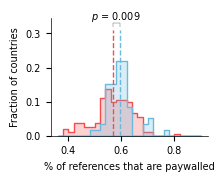

In [21]:
from scipy.stats import ttest_ind

bins = [x/100 for x in range(36, 92, 2)]

ax = plt.gca()

sns.histplot(
    countryOAQ1, x="PercentNonOA", hue="GlobalSouth", element="step", bins=bins,
    stat="probability", common_norm=False, palette={True: '#f34d4d', False: '#69bade'}
)

whiteMean = countryOAQ1.query('GlobalSouth==False').PercentNonOA.mean()
nonWhiteMean = countryOAQ1.query('GlobalSouth==True').PercentNonOA.mean()

print(f'Global north average {whiteMean:.4f}, global south average {nonWhiteMean:.4f}')

plt.plot([whiteMean, whiteMean], [0, 0.31], color='#69bade', lw=1, ls='--')
plt.plot([nonWhiteMean, nonWhiteMean], [0, 0.31], color='#f34d4d', lw=1, ls='--')

tstat, p = ttest_ind(
    countryOAQ1.query('GlobalSouth==False').PercentNonOA,
    countryOAQ1.query('GlobalSouth==True').PercentNonOA
)

plotPvalue(ax, [whiteMean, nonWhiteMean], 0.31, pVal=p, gap=0.01, vlength=0.01)


set_size(4*cm, 3*cm, ax)

ax.set_xlabel('% of references that are paywalled')
ax.set_ylabel('Fraction of countries')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend([],[], frameon=False)

plt.savefig('../figures/nonOA_distribution_Q1.pdf',bbox_inches = 'tight', pad_inches = 0)

In [22]:
tstat, p

(2.636060438620066, 0.008984825793411153)

In [23]:
cohen_d(
    countryOAQ1.query('GlobalSouth==False').PercentNonOA,
    countryOAQ1.query('GlobalSouth==True').PercentNonOA
)

0.4005087812940047

Global north average 0.4923, global south average 0.4698


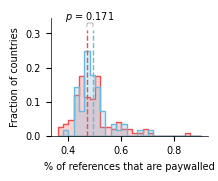

In [24]:
from scipy.stats import ttest_ind

bins = [x/100 for x in range(36, 92, 2)]

ax = plt.gca()

sns.histplot(
    countryOAT3, x="PercentNonOA", hue="GlobalSouth", element="step", bins=bins,
    stat="probability", common_norm=False, palette={True: '#f34d4d', False: '#69bade'}
)

whiteMean = countryOAT3.query('GlobalSouth==False').PercentNonOA.mean()
nonWhiteMean = countryOAT3.query('GlobalSouth==True').PercentNonOA.mean()

print(f'Global north average {whiteMean:.4f}, global south average {nonWhiteMean:.4f}')

plt.plot([whiteMean, whiteMean], [0, 0.31], color='#69bade', lw=1, ls='--')
plt.plot([nonWhiteMean, nonWhiteMean], [0, 0.31], color='#f34d4d', lw=1, ls='--')

tstat, p = ttest_ind(
    countryOAT3.query('GlobalSouth==False').PercentNonOA,
    countryOAT3.query('GlobalSouth==True').PercentNonOA
)

plotPvalue(ax, [whiteMean, nonWhiteMean], 0.31, pVal=p, gap=0.01, vlength=0.01)


set_size(4*cm, 3*cm, ax)

ax.set_xlabel('% of references that are paywalled')
ax.set_ylabel('Fraction of countries')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend([],[], frameon=False)

plt.savefig('../figures/nonOA_distribution_T3.pdf',bbox_inches = 'tight', pad_inches = 0)

In [25]:
tstat, p

(1.3735108780782825, 0.17099799793544834)

In [26]:
cohen_d(
    countryOAT3.query('GlobalSouth==False').PercentNonOA,
    countryOAT3.query('GlobalSouth==True').PercentNonOA
)

0.20885492802431058

## Plot map

In [27]:
import math

def assignColor(row, col, baseline):
    try:
        diff = baseline-int(row[col]) # difference between the current bin and the baseline bin
        assert(4-diff >=0 and 4-diff < 10) # 10 being the total number of colors
        
        return colorSeq[4 - diff] # 4 is the index of the last green color
    except Exception as e:
        
        print('ERROR', e)
        return np.nan

def getPercentile(df, col, N, cutoff=None):
    
    # N: number of percentile bins
    # cutoff: below and above cutoff should be two different colors
    
    df = (
        df
        .assign(percentile = lambda df: 
                  df[col].rank(pct=True, method='max')
                  .apply(lambda x: math.ceil((x*N))) # round up percentile score
                 )
        .rename(columns={'percentile': f'{col}_Q'})
    )
    binsDf = None
    
    if cutoff is not None:
        
        # split the bin that contains cutoff into 2
        
        bins = df.groupby(f'{col}_Q')[col].max().reset_index().set_index(f'{col}_Q').to_dict()[col]
        
        ### add 1 as a bin cutoff, and shift all following bin index by 1 ###
        prev = None
        midInd = None # index of the last bin below cutoff
        
        for i in range(min(bins.keys()), N+1):
            if bins[i] > cutoff:
                if prev is None:
                    midInd = i
                    prev=bins[i]
                    bins[i] = cutoff
                else:
                    bins[i], prev = prev, bins[i]
        bins[N+1] = prev
        
        binsDf = (
            pd.DataFrame.from_dict(bins, orient='index', columns=[f'{col}_max'])
            .reset_index().rename(columns={'index': f'{col}_Q'})
            .assign(Color = lambda df: df.apply(lambda row: assignColor(row, f'{col}_Q', baseline=midInd), axis=1))
        )
        ######
        
        df = df.drop([f'{col}_Q'], axis=1)

        df = getColor(df, binsDf, col)
    
    return df, binsDf

def getColor(df, bins, col):

    cols = cols = df.columns.to_list()

    return (
        df
        .assign(key=1).merge(bins.assign(key=1), on='key')
        .query(f'{col} <= {col}_max')
        .groupby(cols)[f'{col}_Q'].min().reset_index()
        
        .merge(bins[[f'{col}_Q', 'Color']], on=f'{col}_Q')
    )

import geopandas

def produceMap(df, unit='country_code'):
    
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

    world = (
        geopandas.read_file(url)
        [['NAME','ISO_A3','ISO_A2','CONTINENT','geometry']]
        .rename(columns={'ISO_A3':'iso3','ISO_A2':'country_code','NAME':'name','CONTINENT':'continent'})
    )
    print(world.shape)

    world.loc[world.name == 'Taiwan', 'country_code'] = 'CN'
    world.loc[world.name == 'Norway', 'country_code'] = 'NO'
    world.loc[world.name == 'France', 'country_code'] = 'FR'

    world = (
        world.pipe(printShape, cols=['country_code'])

        .query('continent != "Antarctica"')
        .drop(['continent'], axis=1)
        .pipe(printShape, cols=['country_code'], msg='remove Antarctica')

        .query('country_code != "-99"')
        .pipe(printShape, cols=['country_code'], msg='remove unrecognized countries')

        .dissolve(by='country_code').reset_index()
        .pipe(printShape, cols=['country_code'], msg='one china')

        .merge(df, on='country_code')
        .pipe(printShape, cols=[unit, 'country_code'], msg='data to plot')
    )

    if unit != 'country_code':
        world = (
            world
            .dissolve(by=unit).reset_index()
            .pipe(printShape, cols=[unit], msg='aggregate within unit')

            [['geometry', unit]] 
        )
    
    return world

def plotMap(df, col, ax=None, numBins=5, colorCutoff=None, minTotal=100, cax=None, figsize=(24*cm, 6*cm)):
    
    world = produceMap(df)

    if colorCutoff is None:
        colorCutoff = world.query(f'Total >= {minTotal}')[col].median()
    
    relativeBins, bins = getPercentile(
        world.query(f'Total >= {minTotal}')[['country_code',col]],
        col, numBins, colorCutoff
    )
    
    assert(relativeBins.shape[0] ==  world.query(f'Total >= {minTotal}').shape[0])
    if numBins + 1 != bins.shape[0]:
        print('warning! number of bins', bins.shape[0])

    world = (
        pd.concat([
            world.query(f'Total >= {minTotal}').merge(relativeBins.drop([col], axis=1), on='country_code'),
            world.query(f'Total < {minTotal}').assign(Color='#eeeeee')
        ], ignore_index=True, sort=False)
    )

    print(world.shape, 'should be the same as before')

    if ax is None: ax = plt.gca()

    set_size(figsize[0], figsize[1], ax)

    world.plot(ax = ax, color=world.Color)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if cax is not None:
        plotPallete(bins.Color, list(bins.Relative_max), cax, vertical=True, scale=0.6)
    
    return bins, world

def plotPallete(cSeq, labels, ax=None, vertical=False, scale=1, rounding=1, minVal=0):
    
    n = len(cSeq)
    labels = [minVal] + labels
    
    if vertical:
        if ax is None:
            
            ax = plt.gca()
            set_size(1*cm*scale, n*cm*scale)
    
        ax.set_ylim(0, n)
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        ax.set_yticks([x for x in range(n+1)])
        ax.set_yticklabels([f"{round(x, rounding):g}" for x in labels])
        
        for i in range(n):
            ax.fill_between([0, 1], i, i+1, facecolor=cSeq[i])

In [28]:
colorSeq = [
    '#543005',
    '#8c510a',
    '#bf812d',
    '#dfc27d',
    '#f6e8c3',
    '#c7eae5',
    '#80cdc1',
    '#35978f',
    '#01665e',
    '#003c30'
]

len(colorSeq)

10

(177, 5)
(177, 5)  country_code 174  
(176, 4)  country_code 173  remove Antarctica
(173, 4)  country_code 172  remove unrecognized countries
(172, 4)  country_code 172  one china
(169, 14)  country_code 169  country_code 169  data to plot
(169, 16) should be the same as before


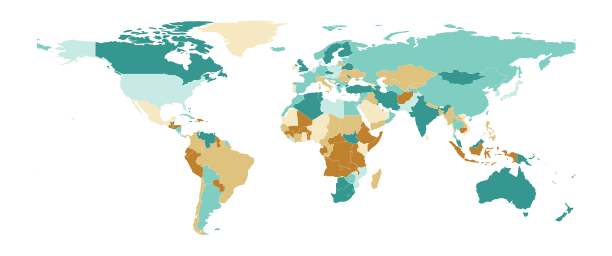

In [29]:
bins, worldMap = plotMap(countryOA, col='PercentNonOA', minTotal=100)

# plt.savefig(f'../figures/OA_map_percentageNonOA.pdf',bbox_inches = 'tight', pad_inches = 0)

In [30]:
bins

,PercentNonOA_Q,PercentNonOA_max,Color
0,1,0.581815,#bf812d
1,2,0.616992,#dfc27d
2,3,0.628945,#f6e8c3
3,4,0.636160,#c7eae5
4,5,0.659945,#80cdc1
5,6,0.727759,#35978f


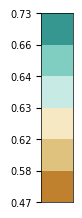

In [31]:
plotPallete(
    bins.Color, list(bins.PercentNonOA_max), vertical=True, scale=0.8,
    rounding=2, minVal=worldMap.PercentNonOA.min()
)

# plt.savefig('../figures/map_legend.pdf', bbox_inches = 'tight', pad_inches = 0)